# Using external inputs to interrogate a model of single neuron

## Useful references

### Python + Numpy + Matplotlib + etc.

* Python Numpy Tutorial: http://cs231n.github.io/python-numpy-tutorial/
* Numpy for MATLAB users: https://docs.scipy.org/doc/numpy-dev/user/numpy-for-matlab-users.html
* MATLAB synonymous commands in Python/NumPy: http://mathesaurus.sourceforge.net/
* Effectively using matplotlib: https://pbpython.com/effective-matplotlib.html


### NEURON (with Python)
* NEURON documentation: https://www.neuron.yale.edu/neuron/static/py_doc/index.html
* NEURON + Python tutorial: https://neuron.yale.edu/neuron/docs/scripting-neuron-basics


Here we demonstrate how to use external inputs to a model neuron to characterize and study its properties.

For this, we need objects to deliver localized perturbation to a neuron, which we call [point processes](https://neuron.yale.edu/neuron/static/py_doc/modelspec/programmatic/mechanisms/mech.html). Today, we will particularly focus on the [`IClamp`](https://neuron.yale.edu/neuron/static/py_doc/modelspec/programmatic/mechanisms/mech.html#IClamp) that can perform current injection into a neuron --- a simulation of the current clamp experiment.

We first start with importing necessary modules, including `neuron`

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from neuron import h, gui

Then, we load a model of a cortical pyramidal cell model

In [2]:
import libcell

cell = libcell.L23()

	0 
	1 
	1 
	1 
	1 


We can inspect the model by `psection`

In [6]:
h.psection()

soma { nseg=7  L=9.26604  Ra=100
	/*location 0 attached to cell 0*/
	/* First segment only */
	insert capacitance { cm=1}
	insert morphology { diam=29.7838}
	insert pas { g_pas=0.000142857 e_pas=-75}
}


1.0

In [7]:
cell.dends[:5]

[dend1_1, dend1_11, dend1_111, dend1_1111, dend1_1112]

In [8]:
cell.dends[0].psection()

{'point_processes': {},
 'density_mechs': {'pas': {'g': [0.00014285714285714287,
    0.00014285714285714287,
    0.00014285714285714287,
    0.00014285714285714287,
    0.00014285714285714287,
    0.00014285714285714287,
    0.00014285714285714287],
   'e': [-75.0, -75.0, -75.0, -75.0, -75.0, -75.0, -75.0],
   'i': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]}},
 'ions': {},
 'morphology': {'L': 4.239810963870551,
  'diam': [2.449559450149536,
   2.449559450149536,
   2.449559450149537,
   2.4495594501495357,
   2.449559450149537,
   2.449559450149537,
   2.449559450149534],
  'pts3d': [(0.0, 0.0, 9.266039848327637, 2.449559450149536),
   (0.07000026851892471,
    0.13999786972999573,
    11.646039962768555,
    2.449559450149536),
   (-0.07000026851892471,
    -0.7700015902519226,
    13.2560396194458,
    2.449559450149536)],
  'parent': soma(1),
  'trueparent': soma(1)},
 'nseg': 7,
 'Ra': 100.0,
 'cm': [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 'regions': set(),
 'species': set(),
 'name': 'dend

Here we load a session file for the virtual current clamp experiment:

In [9]:
h.xopen("iclamp.ses")

1.0

Loading this session embeds a current clamp electrode `h.IClamp[0]`, whose parameters are:

In [12]:
print('Activation onset = {} ms\nDuration = {} ms\nAmplitude = {} nA'.format(
        h.IClamp[0].delay, h.IClamp[0].dur, h.IClamp[0].amp))



Activation onset = 0.0 ms
Duration = 0.0 ms
Amplitude = 0.0 nA


You can control the location and parameters via the "PointProcessManager" window. Now let's run simulation while recording the membrane potential at soma.

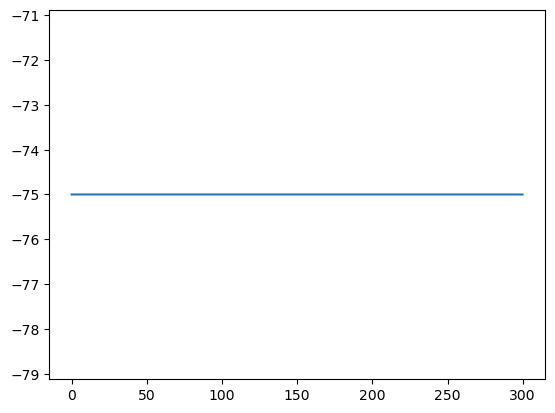

In [11]:
def run(tstop=300):
    """runs a simulation and returns the membrane potential recording at the soma."""
    dt = 0.1 # Again we use 10kHz sampling rate, e.g. 0.1 ms interval
    vrec = h.Vector() # The recording will be save in this vector
    vrec.record(cell.soma(0.5)._ref_v, dt)
    
    h.v_init = -75
    
    h.tstop = tstop  # Set how long the simulation will run.
    h.init()
    h.run()
    
    return vrec.c() # Should return a copy of the vector

vrec = run()
t = np.arange(vrec.size())*0.1
plt.plot(t, vrec)

Let's collect multiple recordings in a list and also make a note about where the electrode was. First, we prepare two empty lists, one for voltage recordings and the other for electrode-to-soma distance:

In [13]:
# Reset lists
vrecs = []
distances = []

# Set the origin to cell.soma(0) 
# See https://www.neuron.yale.edu/neuron/static/py_doc/modelspec/programmatic/topology/geometry.html#distance
h.distance(sec=cell.soma)

0.0

In [14]:
result = run()
vrecs.append(result)

# Measure a distance to the origin from the electrode
distances.append(
    h.distance(h.IClamp[0].get_segment())
) 
print("Number of simulations ran =", len(vrecs), 
     ", Distance = ", h.distance(h.IClamp[0].get_segment()), "um")

Number of simulations ran = 1 , Distance =  118.53142066284826 um


[Text(0.5, 0, 'time (ms)'), Text(0, 0.5, 'Voltage (mV)')]

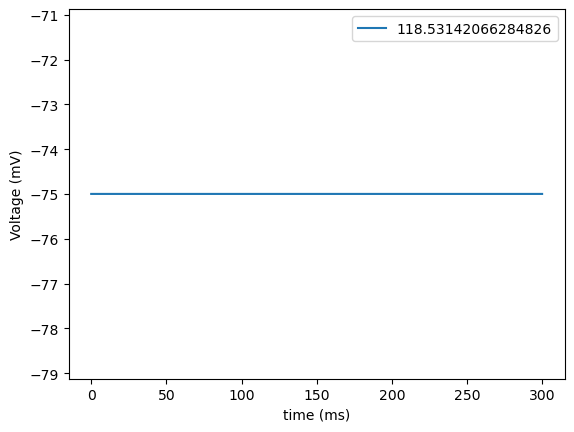

: 

In [15]:
fig,ax = plt.subplots()

t = np.arange(3000)*0.1 # Remember that we use 10kHz for a sampling rate
for v in vrecs:
    ax.plot(t, v)
ax.legend(distances)
ax.set(xlabel='time (ms)', ylabel='Voltage (mV)')

## * How to locate and move point processes

### 1. How to find out the electrode location

`PointProcess.get_segment()` returns the segment that a point process is located.



In [28]:
sec = h.IClamp[0].get_segment()
sec

dend3_11(0.5)

Now we can measure the distance between any section(0) to this electrode using `h.distance`. For example,

In [29]:
h.distance(sec=cell.soma) # Set an origin to cell.soma(0)
h.distance(h.IClamp[0].get_segment()) # Measure a distance to the origin from the electrode

35.49267548868248

### 2. How to find and get a particular section/segment

Here's how find all sections and segments in our `cell`:
* `h.allsec()` yields an iterator to go through all the sections in a model,
* Given a section, say `sec`, `sec.allseg()` yields an iterator for all segments in `sec`,
* If we know a particular location in terms of the relative coordinate `x`, we can use `sec(x)`,

Here is an example of going through all segments in a model with showing their distance to the soma:

In [30]:
print('segment , distance')
for sec in h.allsec():
    for seg in sec.allseg():
        segname = '{}({})'.format(sec.name(), seg.x)
        h.distance(sec=cell.soma) # set origin first at the soma
        print(segname, ',', h.distance(seg)) #print segment and distance from the soma

segment , distance
dend1_1(0.0) , 9.266039848327637
dend1_1(0.07142857142857142) , 9.568883488604104
dend1_1(0.21428571428571427) , 10.17457076915704
dend1_1(0.35714285714285715) , 10.780258049709976
dend1_1(0.5) , 11.385945330262912
dend1_1(0.6428571428571429) , 11.991632610815849
dend1_1(0.7857142857142857) , 12.597319891368784
dend1_1(0.9285714285714286) , 13.203007171921719
dend1_1(1.0) , 13.505850812198187
dend1_11(0.0) , 13.505850812198187
dend1_11(0.07142857142857142) , 14.081184123631715
dend1_11(0.21428571428571427) , 15.23185074649877
dend1_11(0.35714285714285715) , 16.382517369365825
dend1_11(0.5) , 17.53318399223288
dend1_11(0.6428571428571429) , 18.683850615099935
dend1_11(0.7857142857142857) , 19.83451723796699
dend1_11(0.9285714285714286) , 20.98518386083404
dend1_11(1.0) , 21.56051717226757
dend1_111(0.0) , 21.56051717226757
dend1_111(0.07142857142857142) , 22.27148950377046
dend1_111(0.21428571428571427) , 23.693434166776242
dend1_111(0.35714285714285715) , 25.11537882

`PointProcess.loc(segment)` moves the point process to a given segment.

In [31]:
h.IClamp[0].loc(h.dend1_111(0.07142857142857142))

0.07142857142857142

### 3. Example: How to find a segment in `cell` by a name and move our electrode to it.

In [32]:
sec_to_find = [sec for sec in cell.dends if sec.name()=='dend2_12222']
sec_to_find = sec_to_find[0]
sec_to_find

dend2_12222

In [33]:
segs = [seg for seg in sec_to_find.allseg()]
segs

[dend2_12222(0),
 dend2_12222(0.0714286),
 dend2_12222(0.214286),
 dend2_12222(0.357143),
 dend2_12222(0.5),
 dend2_12222(0.642857),
 dend2_12222(0.785714),
 dend2_12222(0.928571),
 dend2_12222(1)]

Then, we move our `IClamp` to the second segment,

In [40]:
h.IClamp[0].loc(segs[7])

0.9285714285714286

Or, we can move it to a middle segment of the section,

In [39]:
h.IClamp[0].loc(sec_to_find(0.5))

0.5

### 4. How to access variables in sections

You can access a variable defined in a section by (section).(variable name). Also, you can change its value by assignment. It is also possible to access/change a variable only for a segment, if a relative coordinate `x` for the segment is known, by (section)(x).(variable name).

In the following example, we go through all the sections in the model and print the name, `g_pas` (conductance parameter of the passive mechanism), and `nseg`. 

In [ ]:
for sec in h.allsec():
    print(sec.name(), sec.g_pas, sec.nseg)

In [ ]:
for sec in h.allsec():
    for seg in sec.allseg():
        h.distance(sec=cell.soma)
        print(sec.name(), h.distance(seg), seg.v)

In [ ]:
h.psection()

Now let's change `g_pas`, the passive conductance, and check the result.

In [ ]:
cell.soma.g_pas = 0.0001
h.psection()